# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Good domestic flight operat...
1,Not Verified | Failed at all basic travel fund...
2,✅ Trip Verified | They lost my baggage in a v...
3,✅ Trip Verified | Late boarding led to a one ...
4,✅ Trip Verified | As usual the flight is delay...


In [4]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
df.head()

,reviews
0,✅ Trip Verified | Good domestic flight operat...
1,Not Verified | Failed at all basic travel fund...
2,✅ Trip Verified | They lost my baggage in a v...
3,✅ Trip Verified | Late boarding led to a one ...
4,✅ Trip Verified | As usual the flight is delay...


In [6]:
df.shape

(1000, 1)

In [7]:
df[['status', 'review']] = df['reviews'].str.split('|', 1, expand=True)
df['status'] = df['status'].str.strip()
df['review'] = df['review'].str.strip()
df = df[['status', 'review']]

In [8]:
df.head()

,status,review
0,✅ Trip Verified,Good domestic flight operated by BA Cityflyer....
1,Not Verified,Failed at all basic travel fundamentals: 1) Ou...
2,✅ Trip Verified,They lost my baggage in a very simple situatio...
3,✅ Trip Verified,Late boarding led to a one hour flight leaving...
4,✅ Trip Verified,As usual the flight is delayed. BA try to blam...


In [9]:
stop_words = set(stopwords.words('english'))
stop_words.add('verified')
stop_words.add('ba')
stop_words.add('one')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Assuming 'reviews' is a column in the DataFrame df
df['clean_review'] = df['review'].apply(clean_text)

In [10]:
df.head()

,status,review,clean_review
0,✅ Trip Verified,Good domestic flight operated by BA Cityflyer....,good domestic flight operated cityflyer ground...
1,Not Verified,Failed at all basic travel fundamentals: 1) Ou...,failed basic travel fundamental 1 flight delay...
2,✅ Trip Verified,They lost my baggage in a very simple situatio...,lost baggage simple situation three week dont ...
3,✅ Trip Verified,Late boarding led to a one hour flight leaving...,late boarding led hour flight leaving two hour...
4,✅ Trip Verified,As usual the flight is delayed. BA try to blam...,usual flight delayed try blame someone inabili...


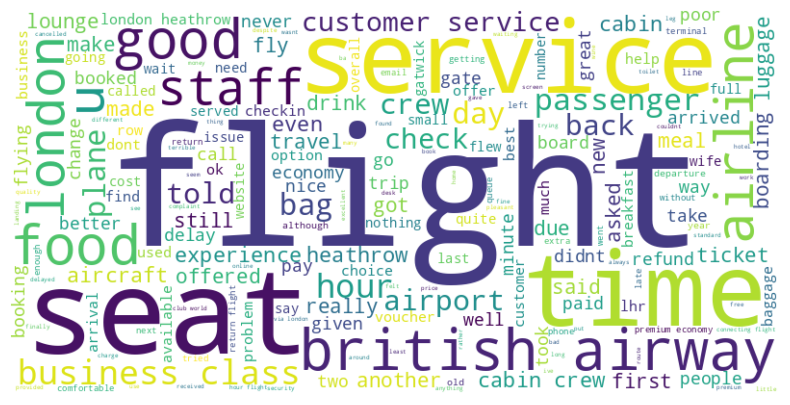

In [11]:
all_reviews = ' '.join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
import random
random.seed(21)
sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_review'].apply(get_sentiment)

In [13]:
df.head()

,status,review,clean_review,sentiment
0,✅ Trip Verified,Good domestic flight operated by BA Cityflyer....,good domestic flight operated cityflyer ground...,positive
1,Not Verified,Failed at all basic travel fundamentals: 1) Ou...,failed basic travel fundamental 1 flight delay...,negative
2,✅ Trip Verified,They lost my baggage in a very simple situatio...,lost baggage simple situation three week dont ...,negative
3,✅ Trip Verified,Late boarding led to a one hour flight leaving...,late boarding led hour flight leaving two hour...,negative
4,✅ Trip Verified,As usual the flight is delayed. BA try to blam...,usual flight delayed try blame someone inabili...,negative


In [14]:
documents = [text.split() for text in df['clean_review']]

dictionary = corpora.Dictionary(documents)

corpus = [dictionary.doc2bow(text) for text in documents]

num_topics = 4
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state = 21)

for topic_id, topic_keywords in lda_model.print_topics():
    top_keywords = [word for word, _ in lda_model.show_topic(topic_id)]
    topic_name = ' '.join(top_keywords[:2])
    print(f'Topic ID: {topic_id}')
    print(f'Topic Name: {topic_name}')
    print(f'Top Keywords: {topic_keywords}')
    print()

Topic ID: 0
Topic Name: flight seat
Top Keywords: 0.016*"flight" + 0.016*"seat" + 0.016*"good" + 0.013*"food" + 0.012*"service" + 0.011*"cabin" + 0.011*"crew" + 0.010*"class" + 0.008*"london" + 0.008*"business"

Topic ID: 1
Topic Name: flight seat
Top Keywords: 0.023*"flight" + 0.011*"seat" + 0.008*"service" + 0.007*"u" + 0.007*"customer" + 0.007*"time" + 0.007*"get" + 0.006*"call" + 0.006*"would" + 0.006*"airline"

Topic ID: 2
Topic Name: flight seat
Top Keywords: 0.024*"flight" + 0.013*"seat" + 0.009*"airway" + 0.009*"british" + 0.008*"refund" + 0.007*"travel" + 0.007*"booked" + 0.007*"service" + 0.006*"london" + 0.006*"airline"

Topic ID: 3
Topic Name: flight hour
Top Keywords: 0.035*"flight" + 0.011*"hour" + 0.010*"time" + 0.009*"service" + 0.009*"london" + 0.008*"seat" + 0.006*"staff" + 0.006*"heathrow" + 0.006*"airline" + 0.006*"crew"



In [15]:
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

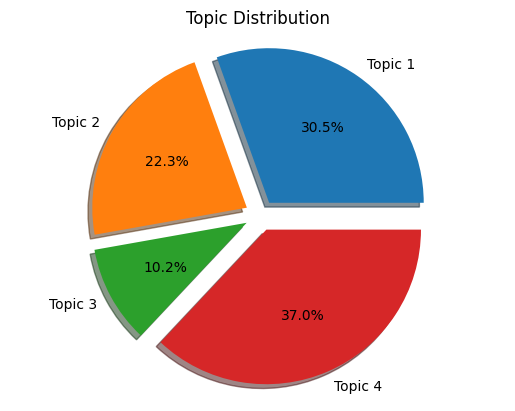

In [16]:
topic_labels = [f'Topic {i+1}' for i in range(num_topics)]
topic_counts = [sum([1 for doc_topics in topic_distribution if max(doc_topics, key=lambda x: x[1])[0] == i]) for i in range(num_topics)]
plt.pie(topic_counts, labels = topic_labels, explode = (0.1, 0.1, 0.1, 0.1), shadow = True, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Topic Distribution')
plt.show()

In [17]:
vectorizer = CountVectorizer(stop_words = stop_words)

X = vectorizer.fit_transform(df['clean_review'])

feature_names = vectorizer.get_feature_names_out()

feature_counts = X.sum(axis=0).A1

feature_dict = dict(zip(feature_names, feature_counts))

sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_features[:10]:
    print(feature, count)

flight 2086
seat 909
service 743
time 593
london 591
hour 528
crew 462
food 460
airline 424
good 416


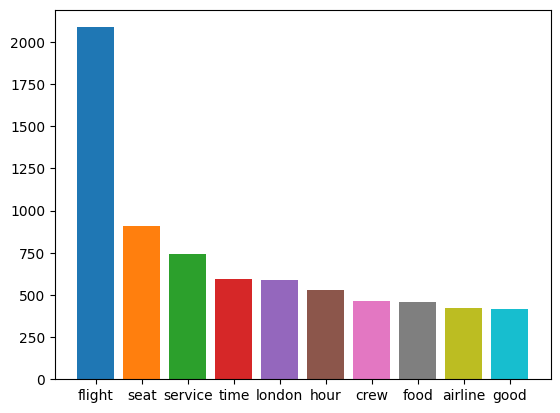

In [18]:
for feature, count in sorted_features[:10]:
    plt.bar(feature, count)
plt.show()

In [19]:
sentiment_count = df['sentiment'].value_counts()
print(sentiment_count)

positive    572
negative    419
neutral       9
Name: sentiment, dtype: int64


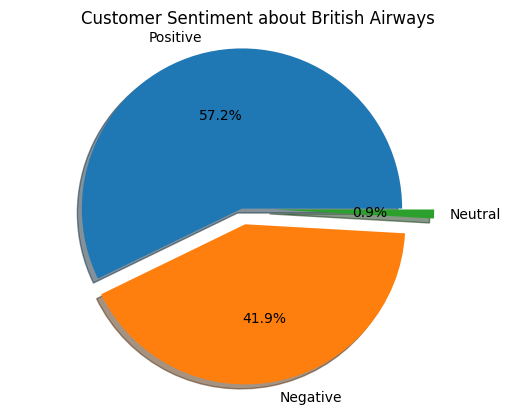

In [20]:
labels = ['Positive', 'Negative', 'Neutral']
plt.pie(sentiment_count, labels = labels, explode = (0, 0.1, 0.2), shadow = True, autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Customer Sentiment about British Airways')
plt.show()

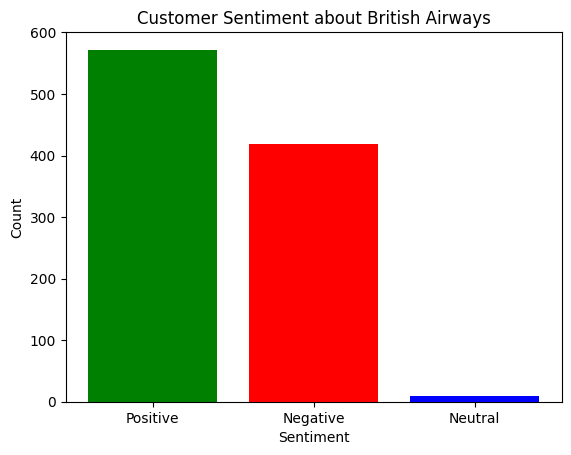

In [21]:
colors = ['green', 'red', 'blue']
plt.bar(labels, sentiment_count, color = colors)
plt.title('Customer Sentiment about British Airways')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

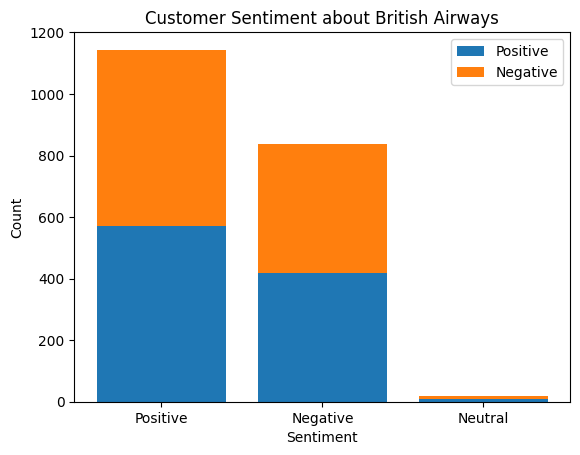

In [22]:
plt.bar(labels, sentiment_count, label='Positive')
plt.bar(labels, sentiment_count, bottom = sentiment_count, label='Negative')
plt.title('Customer Sentiment about British Airways')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.show()

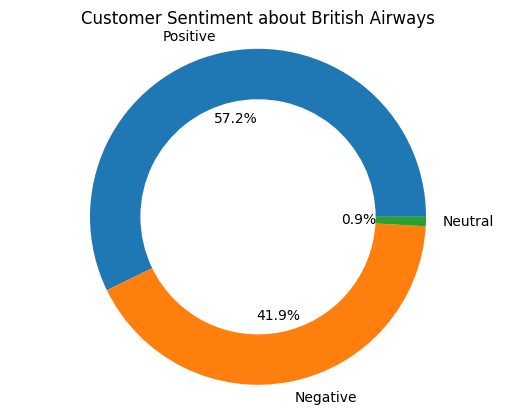

In [23]:
plt.pie(sentiment_count, labels = labels, autopct = '%1.1f%%', wedgeprops = dict(width=0.3))
plt.axis('equal')
plt.title('Customer Sentiment about British Airways')
plt.show()